# Masked Autoencoders Are Scalable Vision Learners

This notebook is a TF2 implementation of [Masked Autoencoders Are Scalable Vision Learners](https://arxiv.org/abs/2111.06377) by He et. al.

The notebook uses the following resources as references:

- https://keras.io/examples/vision/image_classification_with_vision_transformer/

# Imports & Setup

In [1]:
! pip install -q tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [2]:
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import random

# Setting seeds for reproducibility.
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
# DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 512
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 100

# OPTIMIZER
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

# TRAINING
EPOCHS = 10

# AUGMENTATION
IMAGE_SIZE = 72  # We'll resize input images to this size
PATCH_SIZE = 6  # Size of the patches to be extract from the input images
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 8
DEC_NUM_HEADS = 4
DEC_LAYERS = 8
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]  # Size of the transformer layers

# Dataset

Using CIFAR100 for our implementation.

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:40000], y_train[:40000]),
    (x_train[40000:], y_train[40000:]),
)
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

169017344/169001437 [==============================] - 3s 0us/step
Training samples: 40000
Validation samples: 10000
Testing samples: 10000


In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train))
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((x_test))
test_ds = test_ds.prefetch(AUTO)

## Data Augmentation

In [6]:
def get_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(factor=0.02),
            layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        ],
        name="data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [layers.Rescaling(1 / 255.0), layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

# Create Patches

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        # Assuming the image has three channels each patch would be
        # of size (patch_size, patch_size, 3).
        self.resize = layers.Reshape((-1, patch_size * patch_size * 3))

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        # Here we will accept a batch of patches and show a randomly selected image.
        idx = np.random.choice(len(patches))
        print(f"Index selected: {idx}.")
        
        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(NUM_PATCHES))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

    # Useful for the training monitor.
    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patches):
        # This reconstructs one image at a time
        # does not work with batched images.
        patches_tmp = tf.reshape(patches, (NUM_PATCHES, PATCH_SIZE, PATCH_SIZE, 3))
        rows = tf.split(patches_tmp, IMAGE_SIZE // PATCH_SIZE, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

In [8]:
image_batch = next(iter(train_ds))
augmentation_model = get_augmentation_model()
augmeneted_images = augmentation_model(image_batch)
patch_layer = Patches(patch_size=PATCH_SIZE)

Index selected: 102.


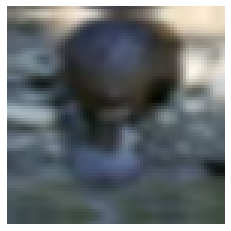

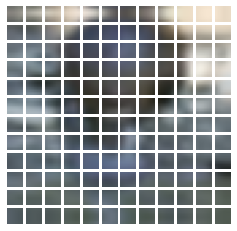

In [9]:
patches = patch_layer(images=augmeneted_images)
patch_layer.show_patched_image(augmeneted_images, patches)

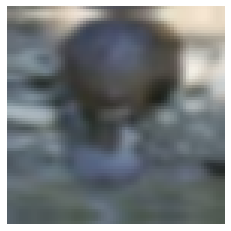

In [10]:
image = patch_layer.reconstruct_from_patch(patches[102])
plt.imshow(image)
plt.axis("off")
plt.show()

# Patch Encoder

In [11]:
class PatchEncoder(layers.Layer):
    def __init__(self, patch_size, projection_dim, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.batch_size = batch_size

        # This is a trainable mask token as suggested in the paper.
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3])
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        # Create the projection layer.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

        # 75% of number of patches should be masked.
        self.num_mask = int(0.75 * self.num_patches)

        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(self.batch_size, self.num_patches)), axis=-1
        )
        self.mask_indices = rand_indices[:, : self.num_mask]
        self.unmask_indices = rand_indices[:, self.num_mask :]

    def call(self, patch):
        # patch shape = (B, num_patches, p*p*3)
        # Get the positional embeddings.
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [self.batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)

        # Embed the patches.
        patch_embeddings = (
            self.projection(patch) + pos_embeddings
        )  # (B, num_patches, projection_dim)

        # The encoder input is the unmasked patch embeddings.
        unmasked_embeddings = tf.gather(
            patch_embeddings, self.unmask_indices, axis=1, batch_dims=1
        )  # (B, unmask_numbers, projection_dim)

        # Get the unmasked and masked positions.
        unmasked_positions = tf.gather(
            pos_embeddings, self.unmask_indices, axis=1, batch_dims=1
        )  # (B, unmask_numbers, projection_dim)
        masked_positions = tf.gather(
            pos_embeddings, self.mask_indices, axis=1, batch_dims=1
        )  # (B, mask_numbers, projection_dim)

        # Repeat the mask token number of mask times
        # mask tokens replace the masks of the image.
        mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
        mask_tokens = tf.repeat(
            mask_tokens[tf.newaxis, ...], repeats=self.batch_size, axis=0
        )

        # Get the masked embeddings.
        masked_embeddings = self.projection(mask_tokens) + masked_positions
        return unmasked_embeddings, masked_embeddings, unmasked_positions

    def show_masked_image(self, patches):
        unmasked_patches = tf.gather(patches, self.unmask_indices, axis=1, batch_dims=1)

        # Necessary for plotting.
        ids = tf.argsort(self.unmask_indices)
        sorted_unmask_indices = tf.sort(self.unmask_indices)
        unmasked_patches = tf.gather(unmasked_patches, ids, batch_dims=1)

        n = int(np.sqrt(NUM_PATCHES))
        unmask_index = sorted_unmask_indices[0]
        unmasked_patch = unmasked_patches[0]

        plt.figure(figsize=(4, 4))

        count = 0
        for i in range(NUM_PATCHES):
            ax = plt.subplot(n, n, i + 1)

            if count < PATCH_SIZE * PATCH_SIZE and unmask_index[count].numpy() == i:
                patch = unmasked_patch[count]
                patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))
                plt.imshow(keras.utils.img_to_array(patch_img))
                plt.axis("off")
                count = count + 1
            else:
                patch_img = tf.zeros((PATCH_SIZE, PATCH_SIZE, 3))
                plt.imshow(keras.utils.img_to_array(patch_img))
                plt.axis("off")
        plt.show()

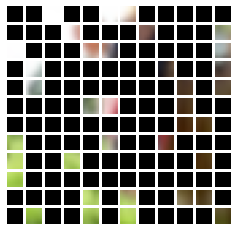

In [12]:
patch_encoder = PatchEncoder(
    patch_size=PATCH_SIZE, projection_dim=PROJECTION_DIM, batch_size=BATCH_SIZE
)
unmasked_embeddings, masked_embeddings, unmasked_positions = patch_encoder(
    patch=patches
)
patch_encoder.show_masked_image(patches)

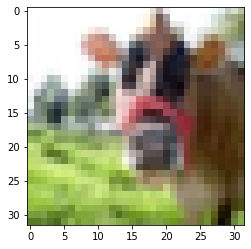

In [13]:
plt.imshow(image_batch[0])
plt.show()

# Multi-Layer Perceptron

In [14]:
def get_mlp(hidden_units, dropout_rate):
    layers_list = []
    for units in hidden_units:
        layers_list.append(layers.Dense(units, activation=tf.nn.gelu))
        layers_list.append(layers.Dropout(dropout_rate))
    
    model = keras.Sequential(layers_list)
    return model

# Encoder

In [15]:
class EncoderLayer(layers.Layer):
    def __init__(self, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads

    def build(self, input_shape):
        (_, self.num_unmask, self.projection_dim) = input_shape
        self.layer_norm1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.layer_norm2 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

        self.add1 = layers.Add()
        self.add2 = layers.Add()

        self.mlp = get_mlp(hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)

        self.mha1 = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.projection_dim // self.num_heads,
            dropout=0.1,
        )

    def call(self, inputs):
        # Layer normalization 1.
        x1 = self.layer_norm1(inputs)
        # Create a multi-head attention layer.
        attention_output = self.mha1(query=x1, value=x1)
        # Skip connection 1.
        x2 = self.add1([attention_output, inputs])
        # Layer normalization 2.
        x3 = self.layer_norm2(x2)
        # MLP.
        x3 = self.mlp(x3)
        # Skip connection 2.
        outputs = self.add2([x3, x2])

        return outputs

In [16]:
class Encoder(layers.Layer):
    def __init__(self, num_layers, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.num_heads = num_heads

    def build(self, input_shape):
        (_, self.num_unmask, self.projection_dim) = input_shape
        self.encoder_layers = [EncoderLayer(num_heads=self.num_heads) for _ in range(self.num_layers)]
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def call(self, inputs):
        for encoder_layer in self.encoder_layers:
            inputs = encoder_layer(inputs)
        
        # Create the encoder ouputs
        encoder_outputs = self.layer_norm(inputs)

        return encoder_outputs

# Decoder

In [17]:
class DecoderLayer(layers.Layer):
    def __init__(self, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads

    def build(self, input_shape):
        (_, self.num_patches, self.projection_dim) = input_shape
        self.layer_norm1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.layer_norm2 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

        self.add1 = layers.Add()
        self.add2 = layers.Add()

        self.mlp = get_mlp(hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)

        self.mha1 = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.projection_dim // self.num_heads,
            dropout=0.1,
        )

    def call(self, inputs):
        # Layer normalization 1.
        x1 = self.layer_norm1(inputs)
        # Create a multi-head attention layer.
        attention_output = self.mha1(query=x1, value=x1)
        # Skip connection 1.
        x2 = self.add1([attention_output, inputs])
        # Layer normalization 2.
        x3 = self.layer_norm2(x2)
        # MLP.
        x3 = self.mlp(x3)
        # Skip connection 2.
        outputs = self.add1([x3, x2])

        return outputs

In [18]:
class Decoder(layers.Layer):
    def __init__(self, num_layers, num_heads, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.patch_size = patch_size

    def build(self, input_shape):
        (_, self.num_patches, self.projection_dim) = input_shape
        self.decoder_layers = [DecoderLayer(num_heads=self.num_heads) for _ in range(self.num_layers)]
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.dense = layers.Dense(
            units=self.patch_size * self.patch_size * 3, activation="sigmoid"
        )

    def call(self, inputs):
        for decoder_layer in self.decoder_layers:
            inputs = decoder_layer(inputs)

        # Create the encoder ouputs.
        decoder_outputs = self.layer_norm(inputs)
        decoder_outputs = self.dense(decoder_outputs)
        return decoder_outputs

# MaskedAutoEncoder Model

This is the trainer model where we encapsulate the training logic.

In [19]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self, augmentation_model, patch_layer, patch_encoder, encoder, decoder, **kwargs
    ):
        super().__init__(**kwargs)
        self.augmentation_model = augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images):
        # Augment the input images.
        augmeneted_images = self.augmentation_model(images)

        # Patch the augmented images.
        patches = self.patch_layer(augmeneted_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
        ) = self.patch_encoder(patches)
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)

        loss_patch = tf.gather(
            patches, self.patch_encoder.mask_indices, axis=1, batch_dims=1
        )
        loss_output = tf.gather(
            decoder_outputs, self.patch_encoder.mask_indices, axis=1, batch_dims=1
        )

        # Compute the total loss.
        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Update the trackers.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

# Model compilation

In [20]:
keras.backend.clear_session()

augmentation_model = get_augmentation_model()
patch_layer = Patches(patch_size=PATCH_SIZE)
patch_encoder = PatchEncoder(
    patch_size=PATCH_SIZE, projection_dim=PROJECTION_DIM, batch_size=BATCH_SIZE
)
encoder = Encoder(num_layers=ENC_LAYERS, num_heads=ENC_NUM_HEADS)
decoder = Decoder(num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, patch_size=PATCH_SIZE)


mae = MaskedAutoencoder(
    augmentation_model=augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

optimizer = tfa.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

mae.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"])

# Training callbacks

In [21]:
# Taking a batch of test inputs to measure model's progress. 
test_images = next(iter(test_ds))
aug_model = get_test_augmentation_model()
test_augmeneted_images = aug_model(test_images)
test_augmeneted_images = test_augmeneted_images[tf.newaxis, ...]

class TrainMonitor(tf.keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval
        
    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval== 0:
            test_patches = self.model.patch_layer(test_augmeneted_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Plot the images.
            idx = np.random.choice(len(test_patches))
            original = self.model.patch_layer.reconstruct_from_patch(test_patches[idx])
            reconstructed = self.model.patch_layer.reconstruct_from_patch(
                test_decoder_outputs[idx]
            )
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
            ax[0].imshow(tf.keras.preprocessing.image.array_to_img(original))
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(tf.keras.preprocessing.image.array_to_img(reconstructed))
            ax[1].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()

In [22]:
train_callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, verbose=1
    ),
    TrainMonitor(epoch_interval=5),
]

# Model training

Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 0.0736 - mae: 0.2235

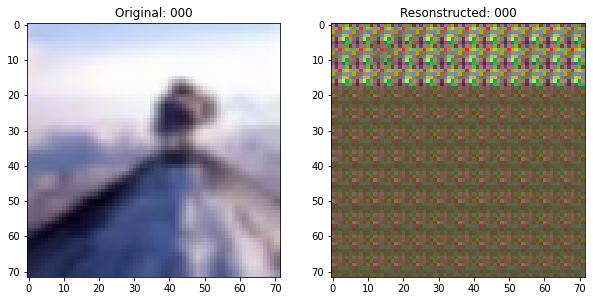

15/15 [==============================] - 21s 533ms/step - loss: 0.0736 - mae: 0.2235 - val_loss: 0.0665 - val_mae: 0.2135 - lr: 0.0010
Epoch 2/10
15/15 [==============================] - 5s 370ms/step - loss: 0.0608 - mae: 0.2033 - val_loss: 0.0539 - val_mae: 0.1912 - lr: 0.0010
Epoch 3/10
15/15 [==============================] - 6s 370ms/step - loss: 0.0500 - mae: 0.1828 - val_loss: 0.0472 - val_mae: 0.1779 - lr: 0.0010
Epoch 4/10
15/15 [==============================] - 5s 369ms/step - loss: 0.0456 - mae: 0.1732 - val_loss: 0.0443 - val_mae: 0.1702 - lr: 0.0010
Epoch 5/10
15/15 [==============================] - 5s 369ms/step - loss: 0.0436 - mae: 0.1682 - val_loss: 0.0429 - val_mae: 0.1666 - lr: 0.0010
Epoch 6/10
15/15 [==============================] - ETA: 0s - loss: 0.0424 - mae: 0.1653

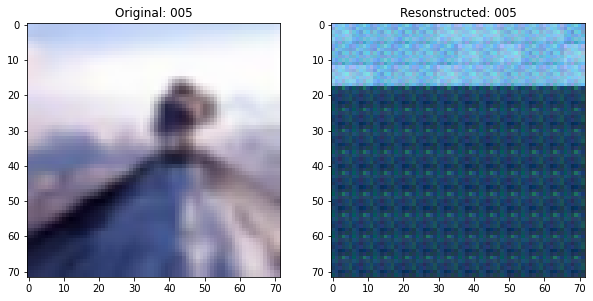

15/15 [==============================] - 6s 399ms/step - loss: 0.0424 - mae: 0.1653 - val_loss: 0.0423 - val_mae: 0.1648 - lr: 0.0010
Epoch 7/10
15/15 [==============================] - 6s 370ms/step - loss: 0.0422 - mae: 0.1646 - val_loss: 0.0422 - val_mae: 0.1651 - lr: 0.0010
Epoch 8/10
15/15 [==============================] - 6s 370ms/step - loss: 0.0419 - mae: 0.1639 - val_loss: 0.0420 - val_mae: 0.1644 - lr: 0.0010
Epoch 9/10
15/15 [==============================] - 5s 370ms/step - loss: 0.0417 - mae: 0.1634 - val_loss: 0.0422 - val_mae: 0.1643 - lr: 0.0010
Epoch 10/10
15/15 [==============================] - 5s 369ms/step - loss: 0.0418 - mae: 0.1636 - val_loss: 0.0420 - val_mae: 0.1640 - lr: 0.0010


In [23]:
history = mae.fit(
    train_ds.take(15),
    epochs=EPOCHS,
    validation_data=val_ds.take(5),
    callbacks=train_callbacks,
)

In [29]:
loss, mae = mae.evaluate(test_ds.batch(BATCH_SIZE, drop_remainder=True))
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

19/19 [==============================] - 2s 121ms/step - loss: 0.0420 - mae: 0.1640
Loss: 0.04
MAE: 0.16
